In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys,os
import numpy as np
import matplotlib.pyplot as plt

##############
#For plotting
import matplotlib.cm as cm

from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True
#rcParams['text.fontsize'] = 18

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

sys.path.append("/Users/bsafdi/Dropbox/galacticB/python/")
sys.path.append("/Users/bsafdi/Dropbox/gmf/")
import galB_models as gB
import gmf 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#gB.B_ASS(-8.5,0,0.01)

In [9]:
# Cas A in Galactic coords
x_sun = -8.5
ell_CA = 111.734745*np.pi/180.0 #rads
b_CA = -02.129570*np.pi/180.0 #rads
d_CA = 3.4 #kpc, to be revised later https://arxiv.org/pdf/astro-ph/0603371.pdf

x_CA = x_sun+d_CA*np.cos(b_CA)*np.cos(ell_CA)
y_CA = d_CA*np.cos(b_CA)*np.sin(ell_CA)
z_CA = d_CA*np.sin(b_CA)
xvec_CA = np.array([x_CA,y_CA,z_CA])
print x_CA,y_CA,z_CA

-9.758184871029112 3.1561065405966744 -0.12634213357527135


In [109]:
# Different B-field models
def Bfunct(xv):
    return np.append(gB.B_ASS(xv[0],xv[1],xv[2]),0.0)+gB.Barm(xv[0],xv[1],xv[2])


GMF0=gmf.GMF()
GMFP = gmf.GMF_Pshirkov()
def arctanM(x,y):
    tmp = np.arctan2(x,y)
    if tmp<0:
        res= 2*np.pi+tmp
    else:
        res = tmp
    return res

def B_GMF(x_vec):
    x,y,z = x_vec
    rho = np.sqrt(x**2+y**2)
    phi = arctanM(y,x)
    rho_hat = np.array([x,y,0.0])/rho
    phi_hat = np.array([-y,x,0.0])/rho
    z_hat = np.array([0.0,0.0,1.0])
    
    disk,_ = GMF0.Bdisk(np.array([rho]),np.array([phi]),np.array([z]))
    halo,_ = GMF0.Bhalo(np.array([rho]),np.array([z]))
    Bx,_ = GMF0.BX(np.array([rho]),np.array([z]))
    
    Btot = rho_hat*(disk[0]+halo[0]+Bx[0])+phi_hat*(disk[1]+halo[1]+Bx[1])+z_hat*(disk[2]+halo[2]+Bx[2])
    return Btot


def B_Psh(x_vec):
    x,y,z = x_vec
    rho = np.sqrt(x**2+y**2)
    phi = arctanM(y,x)
    rho_hat = np.array([x,y,0.0])/rho
    phi_hat = np.array([-y,x,0.0])/rho
    z_hat = np.array([0.0,0.0,1.0])
    
    disk,_ = GMFP.Bdisk(np.array([rho]),np.array([phi]),np.array([z]))
    halo,_ = GMFP.Bhalo(np.array([rho]),np.array([z]))
    
    Btot = rho_hat*(disk[0]+halo[0])+phi_hat*(disk[1]+halo[1])+z_hat*(disk[2]+halo[2])
    return Btot




In [111]:
Bfunct(np.array([-8.5,0,0])), B_GMF(np.array([-8.5,0,0])),B_Psh(np.array([-8.5,0,0]))

(array([ 0.16642205, -0.81799051,  0.        ]),
 array([0.08921106, 0.43848637, 0.24537241]),
 array([0.17431149, 1.9923894 , 0.        ]))

In [112]:
class conversion:
    def __init__(self,xf,Bfunc,xi=np.array([-8.5,0.0,0.00]),ne=2e-2,gagg=1e-11,omega=1.0,ma=1e-12):
        #see https://arxiv.org/pdf/1704.05063.pdf for height
        # consider later using Zi = 0.025, for example
        # ne is electrons / cm^3
        # Bfunc shoul be in microGauss
        # gagg in GeV^{-1}
        # ma in eV
        self._xf = xf
        self._xi = xi
        self._compute_geometry()
        self._Bfunc = Bfunc
        self._ne = ne
        self._gagg = gagg
        self._omega = omega
        self._ma = ma
        self._Delta_gammaI = self._Delta_gamma(omega)
        self._Delta_maI = self._Delta_ma(omega)
    
    def _compute_geometry(self):
        rvec = self._xf - self._xi
        self._d = np.linalg.norm(rvec)
        self._rhat = rvec/self._d
        
        if self._rhat[2]>0:
            N = self._rhat
        else:
            N = - self._rhat
        
        r1 = N[0]
        r2 = N[1]
        self._k1 = 1/np.sqrt(1-r2**2)*np.array([-np.sqrt(1-r1**2-r2**2),0,r1])
        self._k2 = np.sqrt(1-r2**2)*np.array([-r1*r2/(1-r2**2),1,-r2*np.sqrt(1-r1**2-r2**2)/(1-r2**2)])

    def _return_Bs(self,r):
        '''
        r in pc and is distance from the Sun
        '''
        rkpc = r*1e-3
        x = self._xi + rkpc*self._rhat
        Bf = self._Bfunc(x)
        return np.dot(Bf,self._k1), np.dot(Bf,self._k2)
        
    def _Delta_gamma(self,omega):
        '''
        omega in keV
        returns in 1/pc
        '''
        return -1.1e-4*(self._ne/1e-3)*(1./omega) #in 1/pc
    
    def _Delta_ma(self,omega):
        '''
        res in pc, omega in keV
        '''
        return -78.0*(self._ma/1e-9)**2*(1./omega)
    
    def _Delta_Bs(self,r):
        '''
        r in pc and is distance from the Sun
        returns in inverse pc
        '''
        B1, B2 = self._return_Bs(r)
        return 1.5e-2*(B1/1.0e3)*(self._gagg/1e-11),1.5e-2*(B2/1.0e3)*(self._gagg/1e-11)
    
    
    def _RHS(self,y,r):
        A1,A2,a = y
        DeltaB1, DeltaB2 = self._Delta_Bs(r)
        Delta_gamma  = self._Delta_gammaI
        Delta_ma = self._Delta_maI
        
        return [-1j*(Delta_gamma*A1+DeltaB1*a),-1j*(Delta_gamma*A2+DeltaB2*a),-1j*(DeltaB1*A1+DeltaB2*A2+Delta_ma*a)]
        
    def _solve_ODE(self,omega=1.0,Nr=10000):
        self._omega = omega
        self._Delta_gammaI = self._Delta_gamma(omega)
        self._Delta_maI = self._Delta_ma(omega)
        dist = self._d*1e3 #in pc
        
        rs = np.linspace(0,dist,Nr)
        
        RHS = lambda r,y: self._RHS(y,r)
        
        sol = solve_ivp(RHS,[0.0,dist] ,[0.0+0*1j,0.0+0*1j,1.0+0*1j],t_eval=rs)
        self.sol = sol
        self.rs = rs
        prob = np.zeros(Nr)
        for i in range(Nr):
            prob[i] = (np.conj(sol.y[0][i])*sol.y[0][i]+np.conj(sol.y[1][i])*sol.y[1][i])
        self.prob = prob
        return prob[-1]#sol
        
        
        
        
    
                 
                 

In [113]:
#Bfunct(np.array([-8.5,0,0]))

In [114]:
cI0 = conversion(xvec_CA,Bfunct,ma=1e-15) #B_GMF
cI1 = conversion(xvec_CA,B_GMF,ma=1e-15) #B_GMF
cI2 = conversion(xvec_CA,B_Psh,ma=1e-15) #B_GMF

In [115]:
print cI0._return_Bs(1000.0)
print cI1._return_Bs(1000.0)
print cI2._return_Bs(1000.0)

(-0.007885629189881716, -0.23052481025501292)
(0.11452789547679523, 0.8345403353063223)
(-0.04698515531493712, 1.3671175615660816)


In [116]:
print cI0._solve_ODE(omega=50.0) #1.9e-4, without is 1.905e-4
print cI1._solve_ODE(omega=50.0)
print cI2._solve_ODE(omega=50.0)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: ComplexWarning: Casting complex values to real discards the imaginary part


0.00019051910721410762
0.001751335114843207
0.0041137522484791045


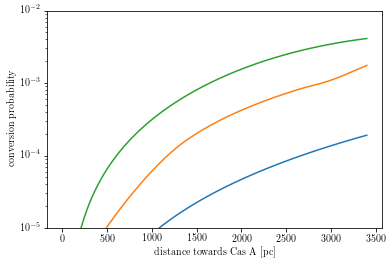

In [123]:
plt.plot(cI0.rs,cI0.prob)
plt.plot(cI1.rs,cI1.prob)
plt.plot(cI2.rs,cI2.prob)
plt.yscale('log')
plt.ylim(1e-5,1e-2)
plt.xlabel("distance towards Cas A [pc]")
plt.ylabel("conversion probability")